In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import random

import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

import heapq
from haversine import haversine, Unit

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [20]:
sentences = ([['@USAirways', 'Trying', 'to', 'change', 'my', 'flight', 'due', 'to', 'NYC', 
                         'travel', 'advisory', '...', 'your', 'online', 'system', 'Cancelled', 'Flighted',
                         'my', 'entire', 'flight', '.'], ['Been', 'on', 'hold', 'for', 'over', '1', 'hr']])

In [69]:
def bigrams(sentence):
    res = []
    prev = "<START>"
    for x in sentence:
        curr = x
        prev = prev.lower()
        curr = curr.lower()
        res.append(str((prev, curr)))
        prev = curr
    res.append(str((curr, "<end>")))
    return res

In [70]:
unique_features = set()
feature_list = sentences
for i in range(len(feature_list)):
    res = (bigrams(feature_list[i]))
    for feat in res:
        unique_features.add(feat)

In [71]:
l = list(unique_features)

In [75]:
sorted(l)

["('.', '<end>')",
 "('...', 'your')",
 "('1', 'hr')",
 "('<start>', '@usairways')",
 "('<start>', 'been')",
 "('@usairways', 'trying')",
 "('advisory', '...')",
 "('been', 'on')",
 "('cancelled', 'flighted')",
 "('change', 'my')",
 "('due', 'to')",
 "('entire', 'flight')",
 "('flight', '.')",
 "('flight', 'due')",
 "('flighted', 'my')",
 "('for', 'over')",
 "('hold', 'for')",
 "('hr', '<end>')",
 "('my', 'entire')",
 "('my', 'flight')",
 "('nyc', 'travel')",
 "('on', 'hold')",
 "('online', 'system')",
 "('over', '1')",
 "('system', 'cancelled')",
 "('to', 'change')",
 "('to', 'nyc')",
 "('travel', 'advisory')",
 "('trying', 'to')",
 "('your', 'online')"]

### Load Data

In [3]:
daily_lead_df = pd.read_csv('../input_data/daily_lead_80_20.csv', encoding = 'latin1')

In [4]:
nascar_tracks_df = pd.read_excel('../input_data/NascarTracks_1980.xlsx')

In [5]:
daily_lead_df.head()

,sitenum,latitude,longitude,Pb_mean,address,statename,countyname,cityname,cbsaname,year,fips,monitorID,month,day,date1
0,3,31.790480,-85.978973,0.05,HENDERSON ROAD,Alabama,Pike,Troy,"Troy, AL",1980,1109,343,1,1,01jan1980
1,6,35.312187,-119.617620,0.05,"HIWAYS 58 & 33, MCKITTRICK, CA.",California,Kern,McKittrick,"Bakersfield, CA",1980,6029,631,1,1,01jan1980
2,1,37.972309,-122.520000,1.10,534 4TH ST.,California,Marin,San Rafael,"San Francisco-Oakland-Hayward, CA",1980,6041,11,1,1,01jan1980
3,2001,39.987762,-104.818580,0.50,15 S. MAIN ST.,Colorado,Adams,Brighton,"Denver-Aurora-Lakewood, CO",1980,8001,2124,1,1,01jan1980
4,1,39.827595,-104.937670,1.00,4301 E 72ND AVE.,Colorado,Adams,Commerce City,"Denver-Aurora-Lakewood, CO",1980,8001,19,1,1,01jan1980


In [6]:
nascar_tracks_df.head()

,track,city,state,country,lat,long,first race,last race,# races
0,Fairgrounds Speedway Nashville - Nashville Sp...,Nashville,TN,US,36.1308,-86.762146,1958,1984,42
1,Riverside International Raceway,Riverside,CA,US,33.931389,-117.272222,1958,1988,48
2,North Wilkesboro Speedway,North Wilkesboro,NC,US,36.1772,-81.144516,1949,1996,93
3,Rockingham Speedway - North Carolina Motor Spe...,Rockingham,NC,US,34.9745,-79.610515,1965,2004,78
4,Chicagoland Speedway,Joliet,IL,US,41.4744,-88.058763,2001,2019,19


In [7]:
nascar_tracks_df['lat'] = nascar_tracks_df['lat'].astype(float)
nascar_tracks_df['long'] = nascar_tracks_df['long'].astype(float)

### Find N closest lead monitoring stations to each track

**Drop duplicates on monitorID to speed up algo**

In [8]:
### Note: discrepancy in #5
filt_lead_df = daily_lead_df.drop_duplicates(["monitorID"]).copy()

**Create one point column based on lat+long columns**

In [9]:
nascar_tracks_df['point'] = [(x, y) for x,y in zip(nascar_tracks_df['lat'], nascar_tracks_df['long'])]
filt_lead_df['point'] = [(x, y) for x,y in zip(filt_lead_df['latitude'], filt_lead_df['longitude'])]

In [10]:
nascar_tracks_clean = nascar_tracks_df.to_pickle("../../21_6_7/notebooks/nascar_tracks_clean.pkl")

In [11]:
daily_lead_unique = filt_lead_df.to_pickle("../../21_6_7/notebooks/daily_lead_unique.pkl")

**Find N closest points**

In [12]:
# Find closest point from a list of points
def closest_point(point, points, monitor_ids, n_smallest=10):
    # finds distance between each track and every monitoring station
    dist = []
    for p in points:
        x = round(haversine(point, p, unit=Unit.MILES), 4)
        dist.append(x)
    
    idxs = list(np.argpartition(dist, range(n_smallest)))[:n_smallest]
    
    n_smallest_points = [points[idx] for idx in idxs] # monitor coordinates
    n_smallest_ids = [monitor_ids[idx] for idx in idxs] # monitor IDs
    n_smallest_dist = [dist[idx] for idx in idxs]

    return n_smallest_points, n_smallest_ids, n_smallest_dist

In [13]:
monitor_points = list(filt_lead_df['point'])
monitor_ids = list(filt_lead_df["monitorID"])

In [14]:
# get only the 10 nearest stations
n_smallest = 10
nascar_tracks_df['closest_points_ids_dist'] = [closest_point(x, monitor_points, monitor_ids, n_smallest) 
                                          for x in nascar_tracks_df['point']]

**Split `closest_points_ids` col into separate cols**

In [15]:
nascar_tracks_df["closest_points"] = nascar_tracks_df["closest_points_ids_dist"].apply(lambda x: x[0])
nascar_tracks_df["closest_ids"] = nascar_tracks_df["closest_points_ids_dist"].apply(lambda x: x[1])
nascar_tracks_df["closest_dist (mi)"] = nascar_tracks_df["closest_points_ids_dist"].apply(lambda x: x[2])

**Create N unique cols for each closest point and id**

In [16]:
point_cols = []
for i in range(1,n_smallest+1):
    new_col = f"closest_point_{i}"
    point_cols.append(new_col)

In [17]:
nascar_tracks_df[point_cols] = pd.DataFrame(nascar_tracks_df["closest_points"].tolist())

In [18]:
for i in range(1,n_smallest+1):
    nascar_tracks_df[f"closest_point_lat_{i}"] = nascar_tracks_df[f"closest_point_{i}"].apply(lambda x: x[0])
    nascar_tracks_df[f"closest_point_long_{i}"] = nascar_tracks_df[f"closest_point_{i}"].apply(lambda x: x[1])

In [19]:
id_cols = []
for i in range(1,n_smallest+1):
    new_col = f"closest_id_{i}"
    id_cols.append(new_col)

In [20]:
nascar_tracks_df[id_cols] = pd.DataFrame(nascar_tracks_df["closest_ids"].tolist())

In [21]:
dist_cols = []
for i in range(1,n_smallest+1):
    new_col = f"closest_dist_{i}"
    dist_cols.append(new_col)

In [22]:
nascar_tracks_df[dist_cols] = pd.DataFrame(nascar_tracks_df["closest_dist (mi)"].tolist())

In [23]:
nearest_10_stations = nascar_tracks_df.copy()

In [24]:
nearest_10_stations.to_pickle("../../21_6_7/notebooks/nearest_10_stations.pkl")

### Visualize N closest points

**All tracks**

In [25]:
geo = [Point(xy) for xy in zip(nascar_tracks_df['long'], nascar_tracks_df['lat'])] # note: (long, lat) order
gdf = GeoDataFrame(nascar_tracks_df, geometry=geo, crs = 4326)   

Text(0.5, 1.0, 'All Tracks')

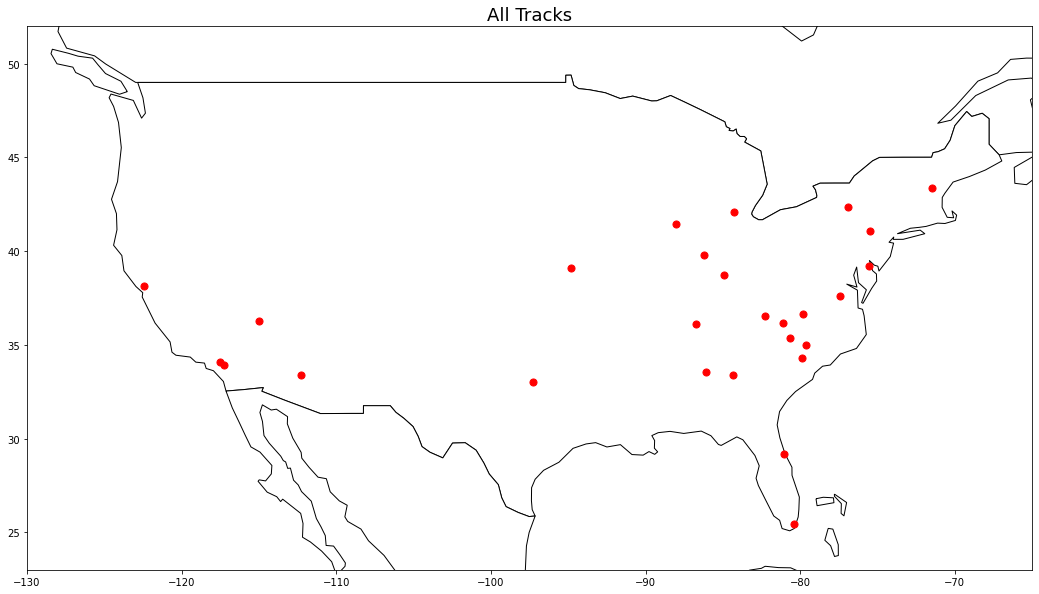

In [26]:
#ax = plt.subplot()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # nybb
base = world.plot(color='white', edgecolor='black', figsize=(20, 10))    
    
ax = gdf.plot(ax=base, marker='o', color='red', markersize=50)
ax.set_xlim(-130,-65)
ax.set_ylim(23,52)
ax.set_title("All Tracks", fontsize=18)

**All tracks and 10 closest monitoring stations**

In [27]:
def get_color(i):
    colors = ["orange","yellow","lime","green","blue","indigo","purple","pink","grey","black"]
    return colors[i-1]

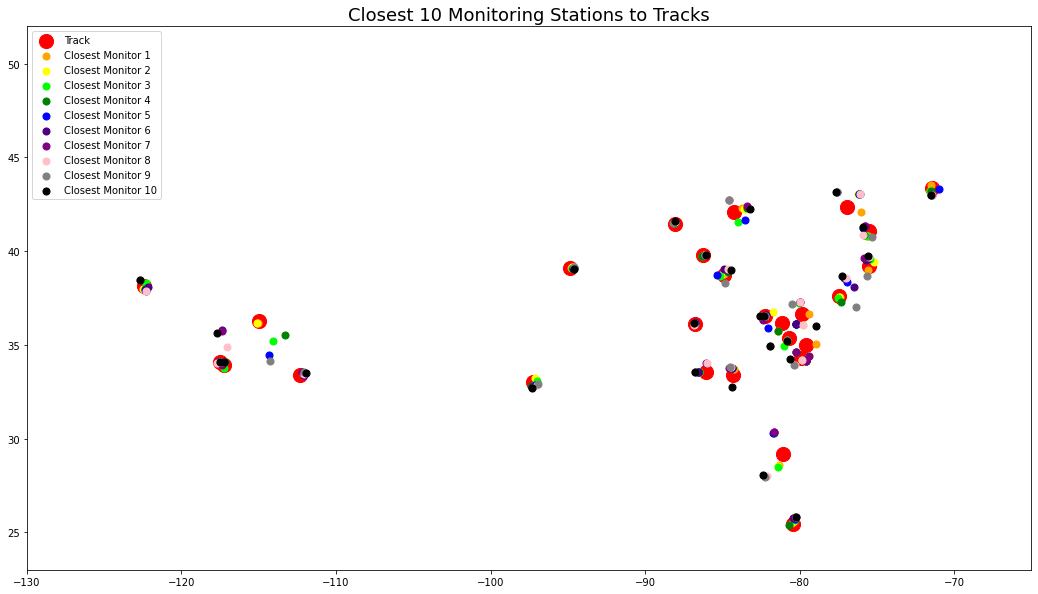

In [28]:
f, ax = plt.subplots(1, figsize=(20,10))

geo = [Point(xy) for xy in zip(nascar_tracks_df['long'], nascar_tracks_df['lat'])] # note: (long, lat) order
gdf = GeoDataFrame(nascar_tracks_df, geometry=geo, crs = 4326)   

ax = gdf.plot(ax=ax, marker='o', color='red', markersize=200, label="Track")

for i in range(1,n_smallest+1):
    lat_col = f"closest_point_lat_{i}"
    long_col = f"closest_point_long_{i}"
    
    # note: (long, lat) order, ie (1,0)
    geo = [Point(xy) for xy in zip(nascar_tracks_df[long_col], nascar_tracks_df[lat_col])]
    gdf = GeoDataFrame(nascar_tracks_df, geometry=geo, crs = 4326)  
    
    #world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    ax = gdf.plot(ax=ax, marker='o', color=get_color(i), markersize=50, label=f"Closest Monitor {i}")
    ax.set_xlim(-130,-65)
    ax.set_ylim(23,52)
    
ax.set_title("Closest 10 Monitoring Stations to Tracks", fontsize=18)
plt.legend()
plt.show()

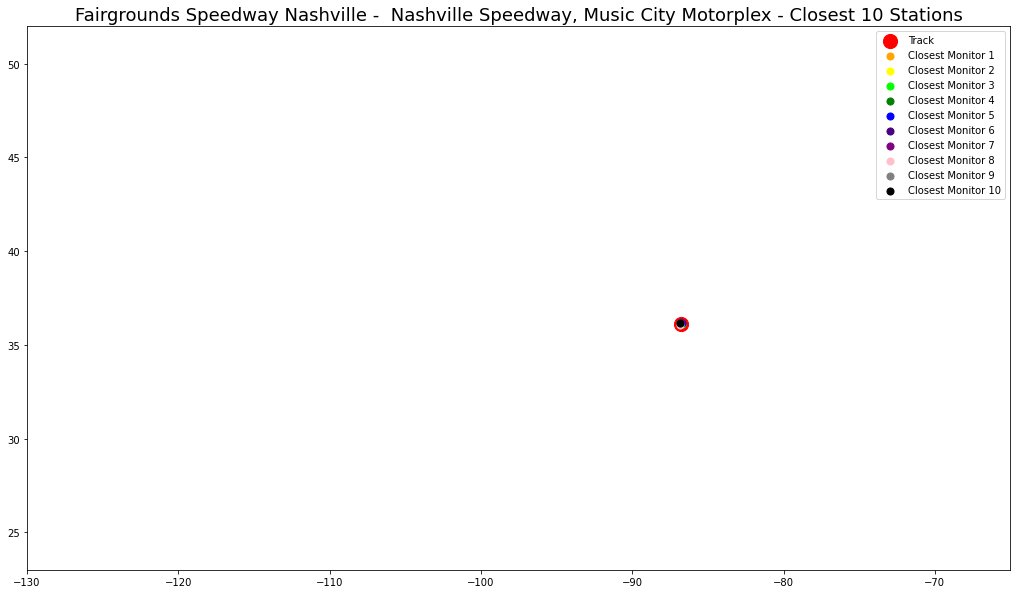

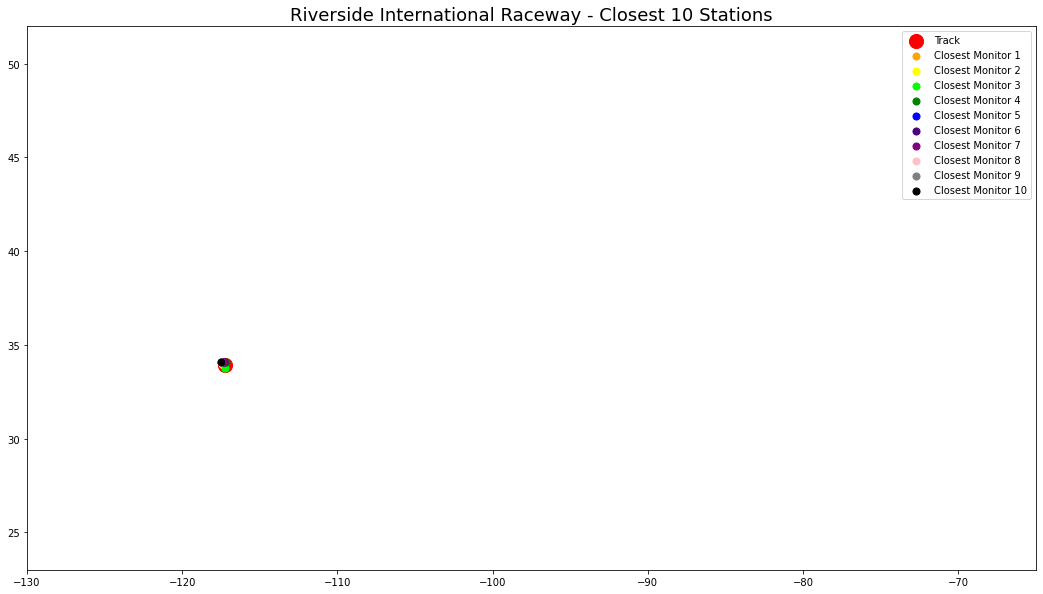

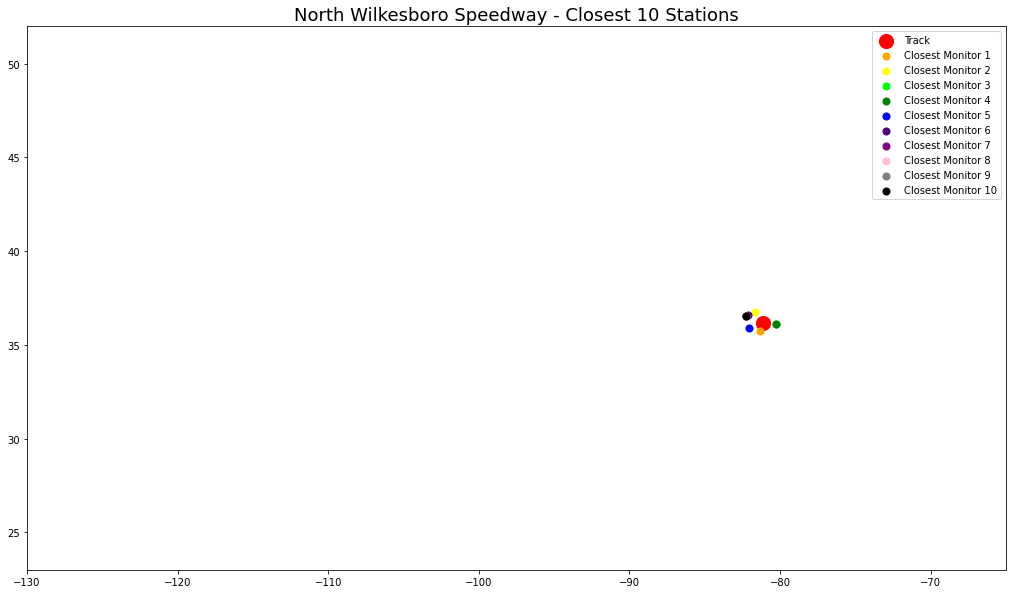

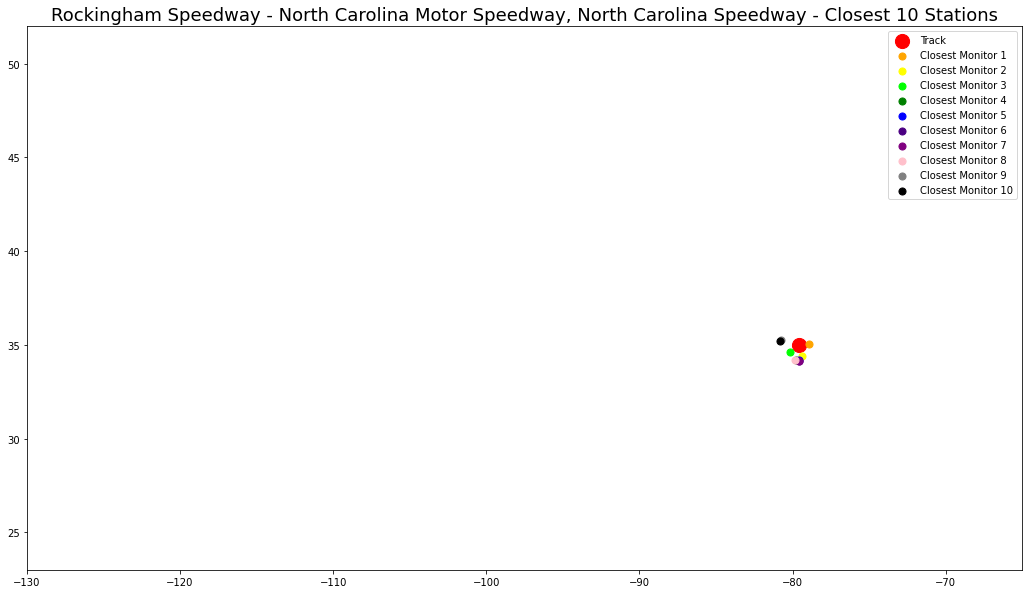

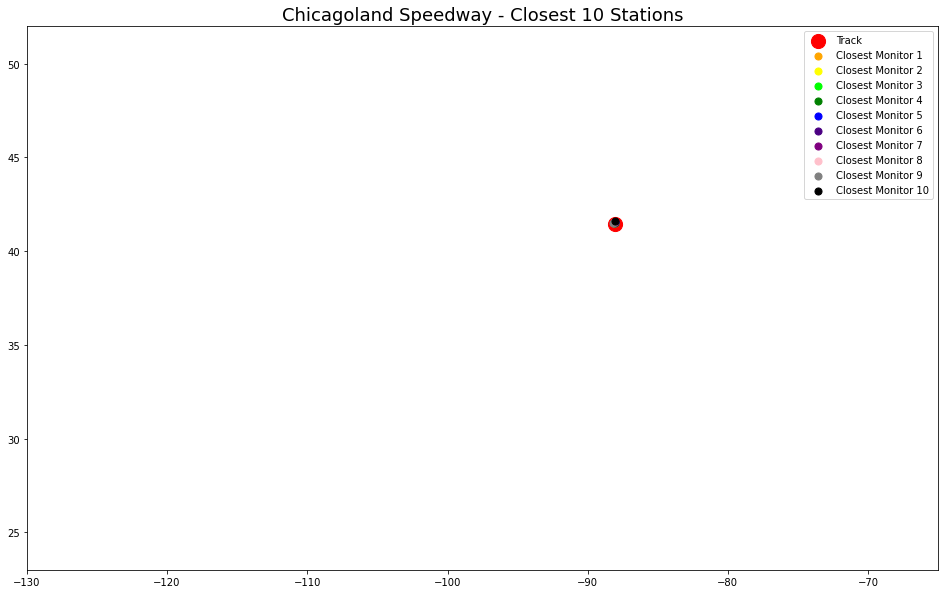

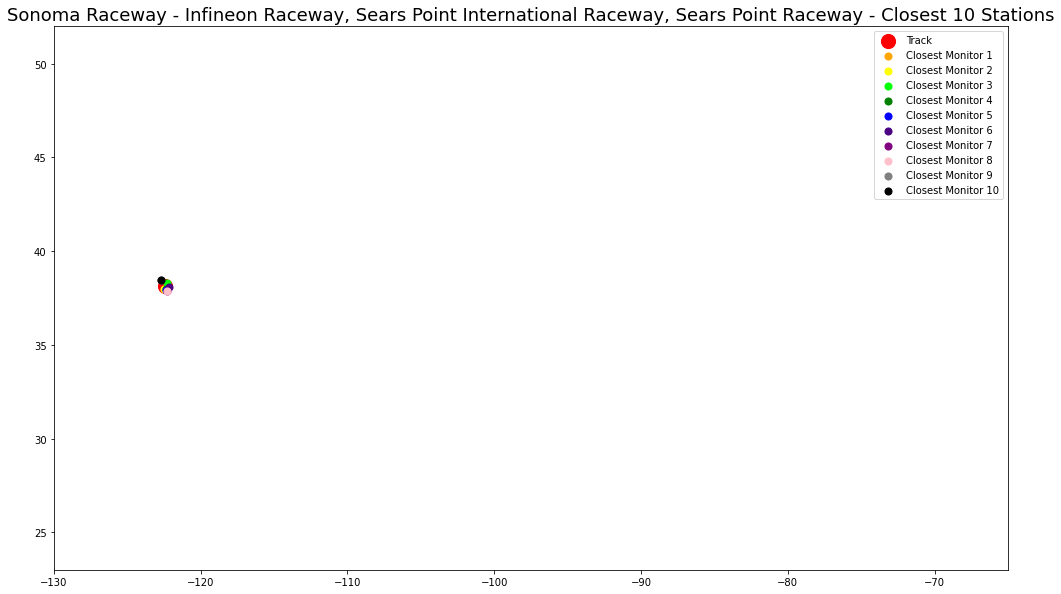

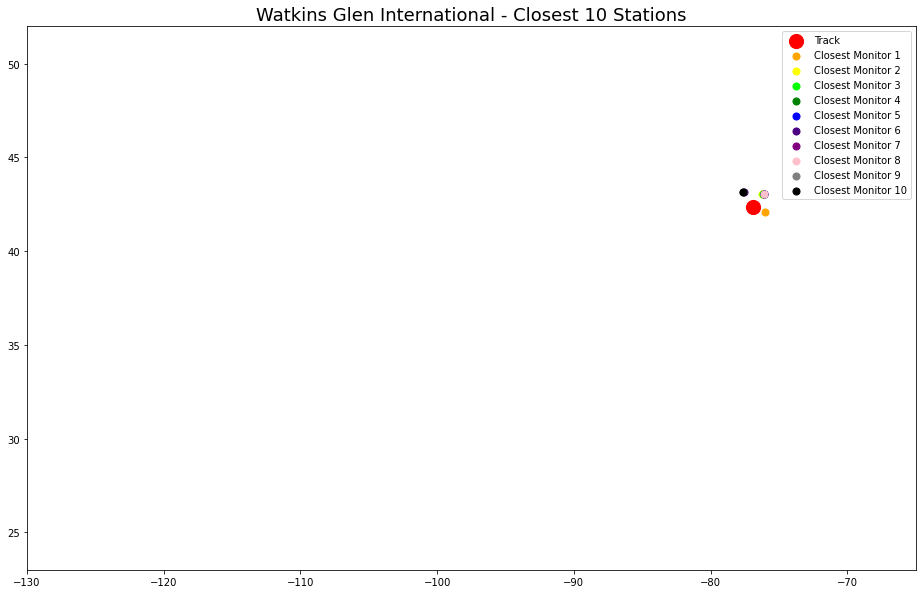

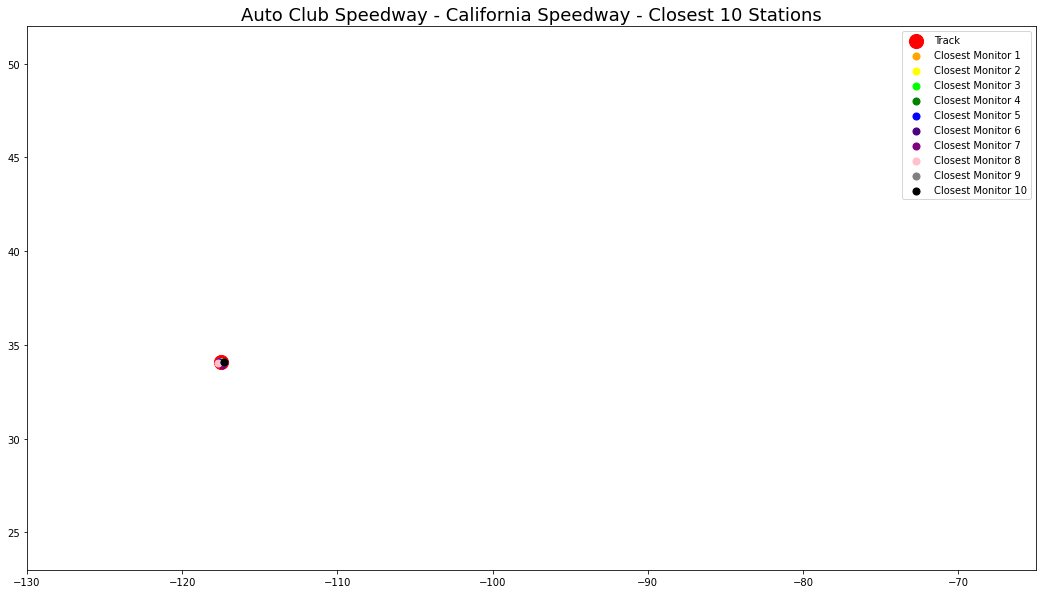

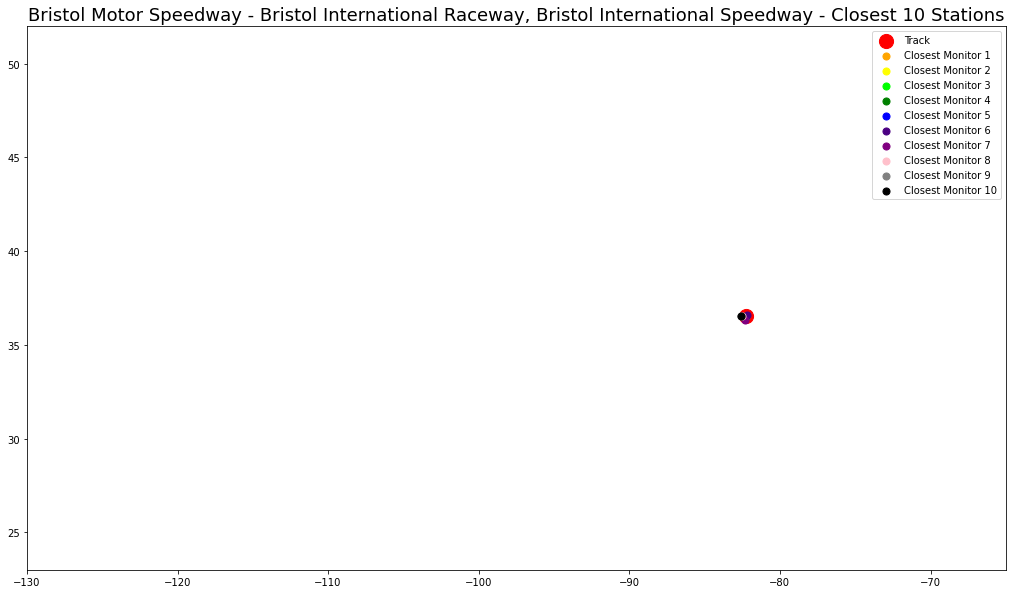

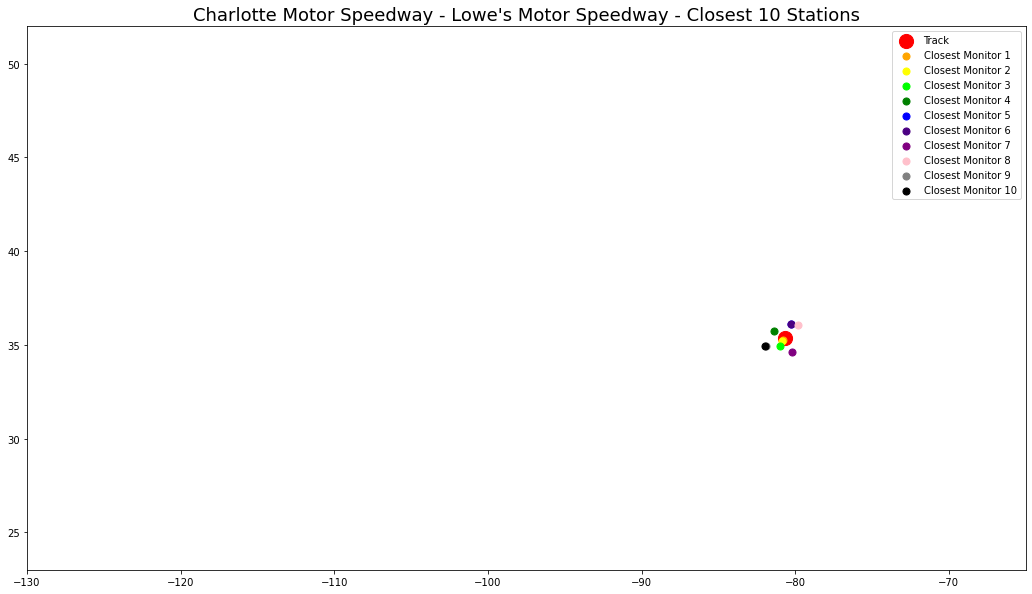

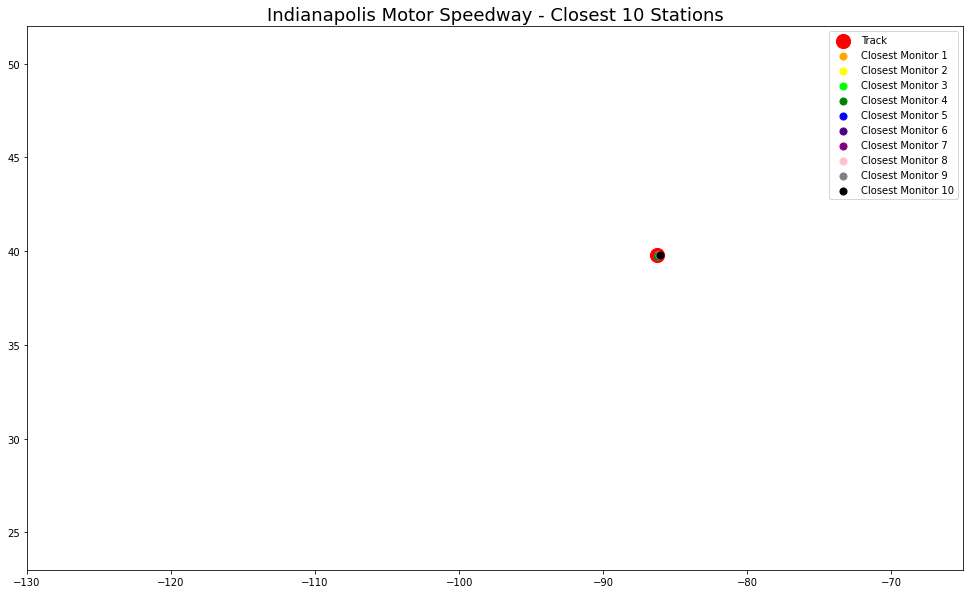

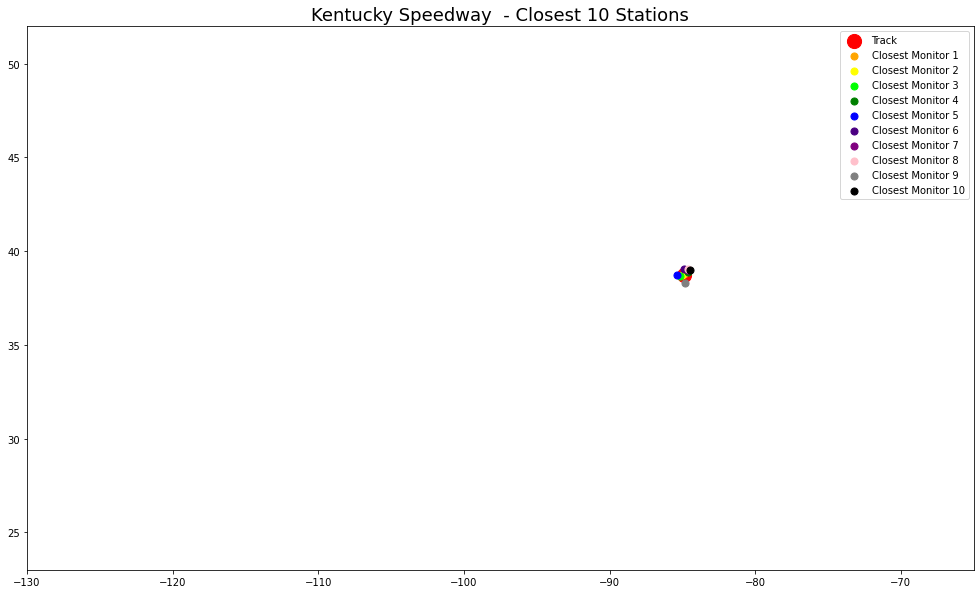

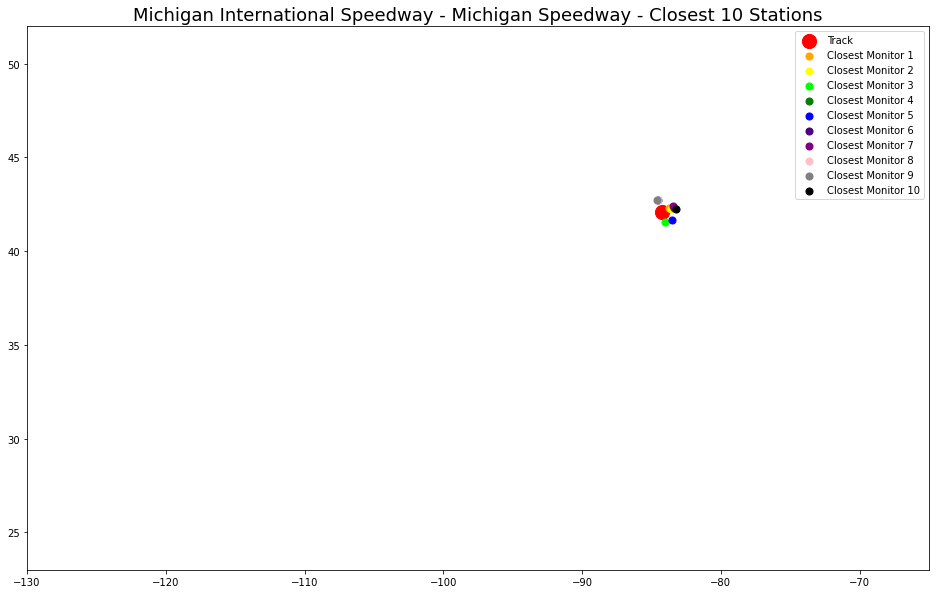

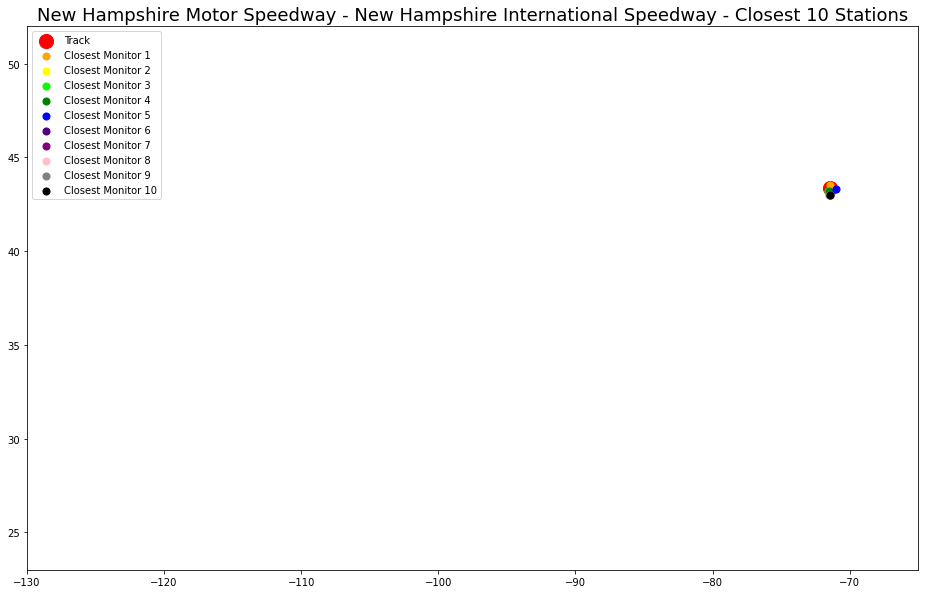

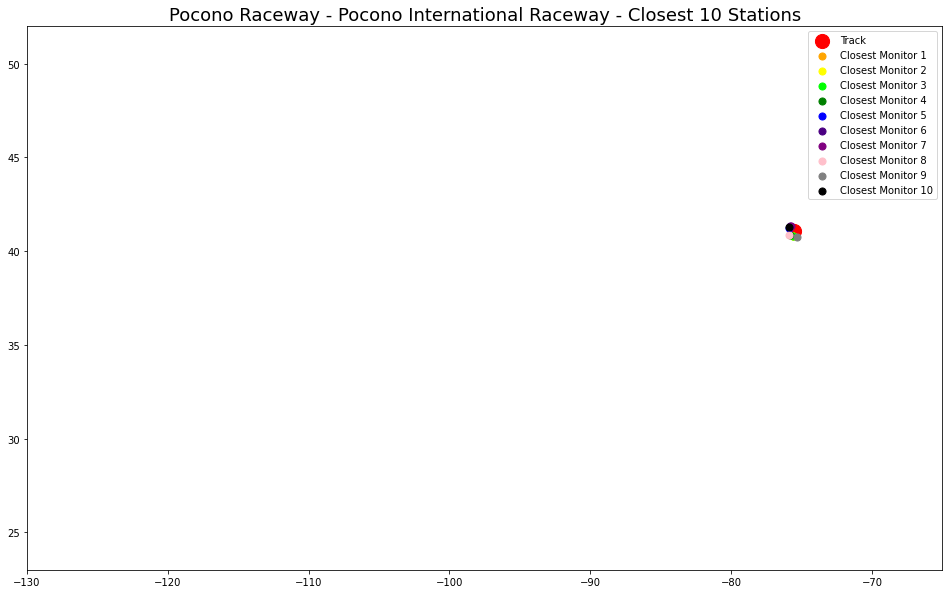

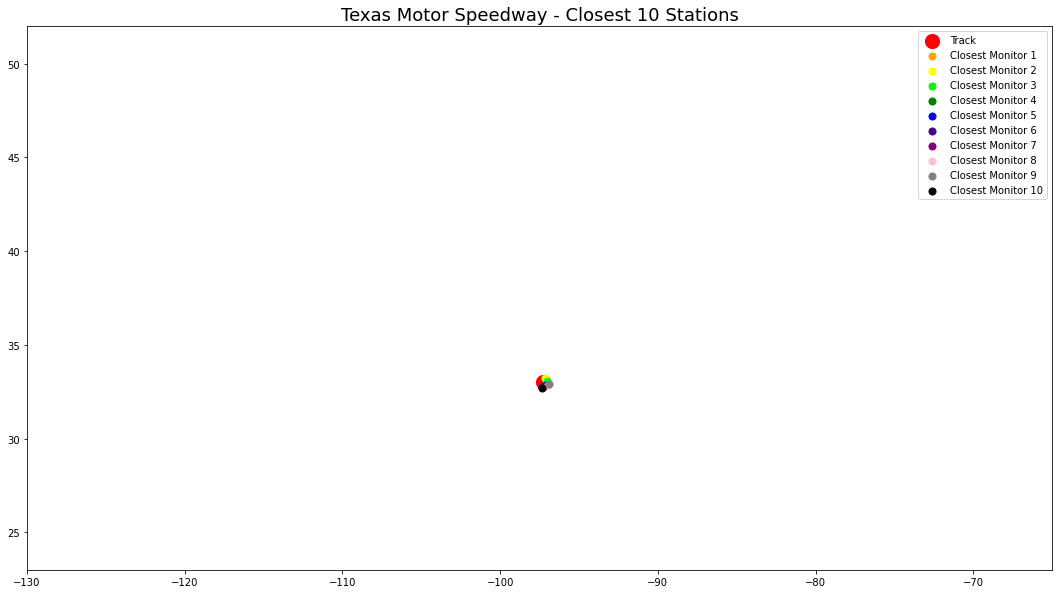

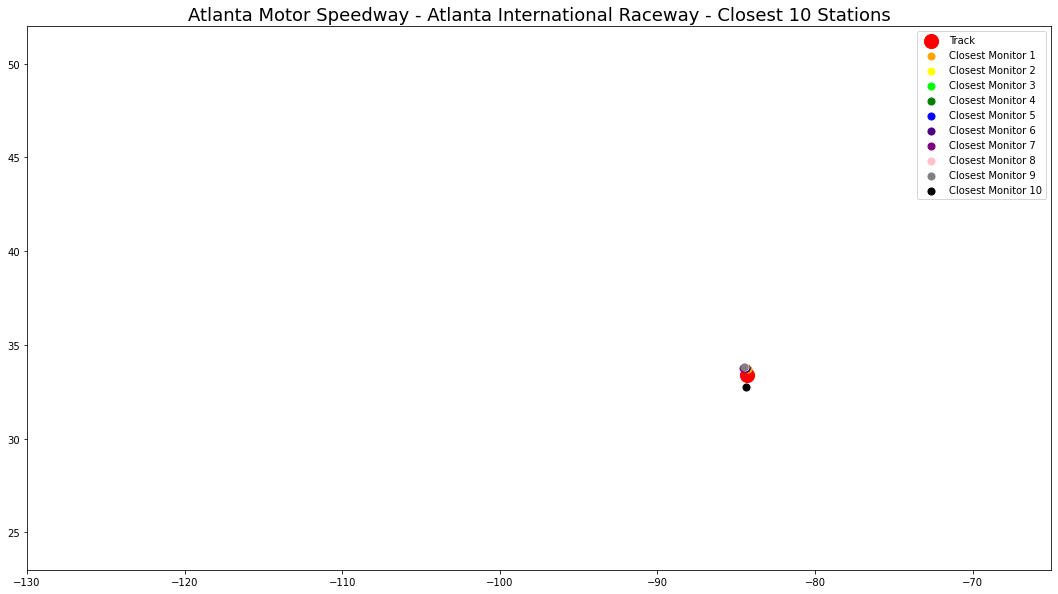

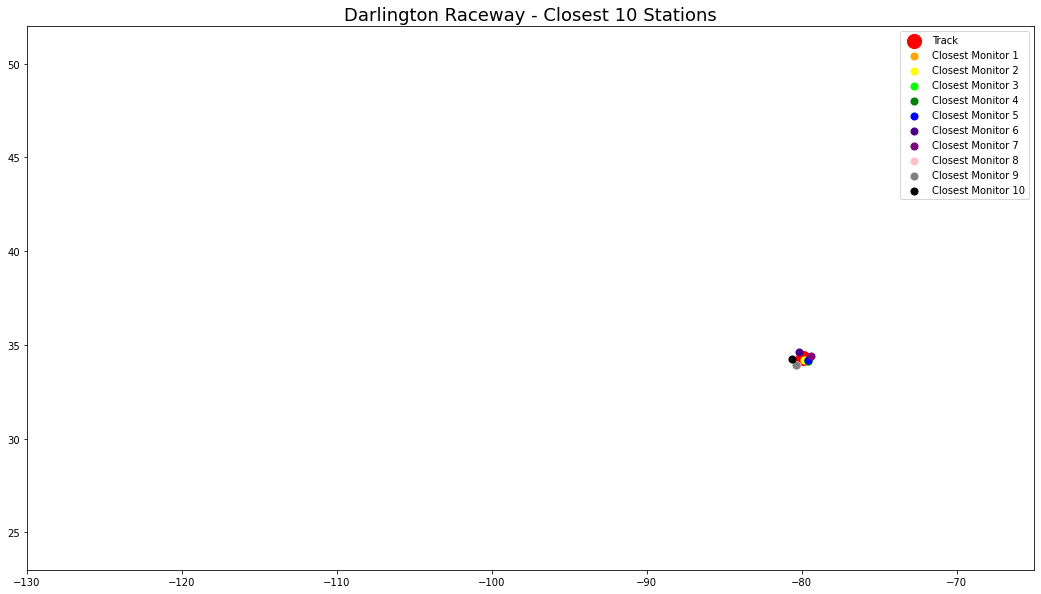

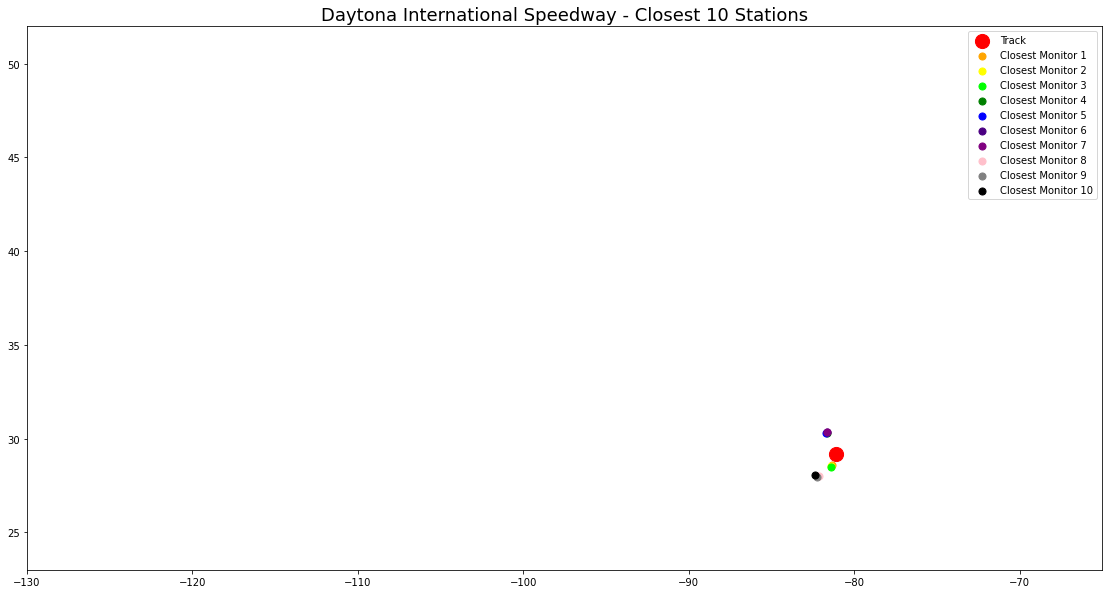

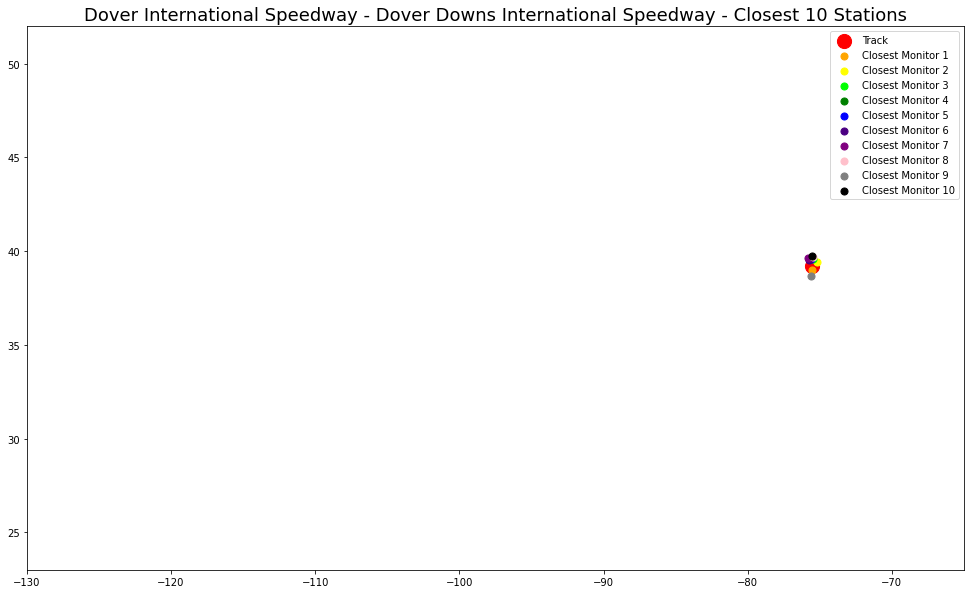

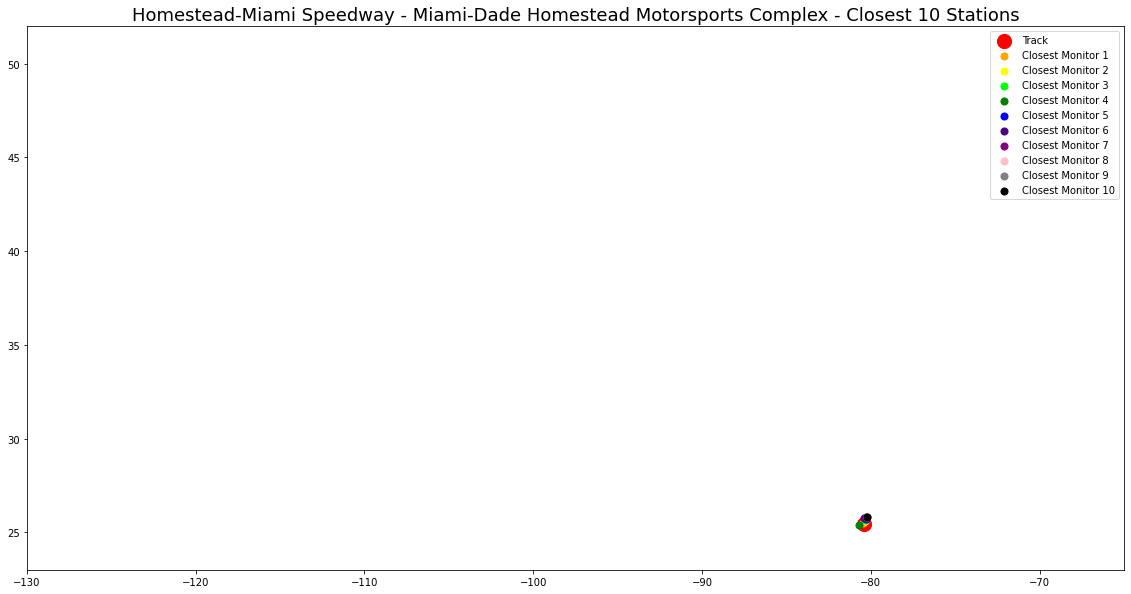

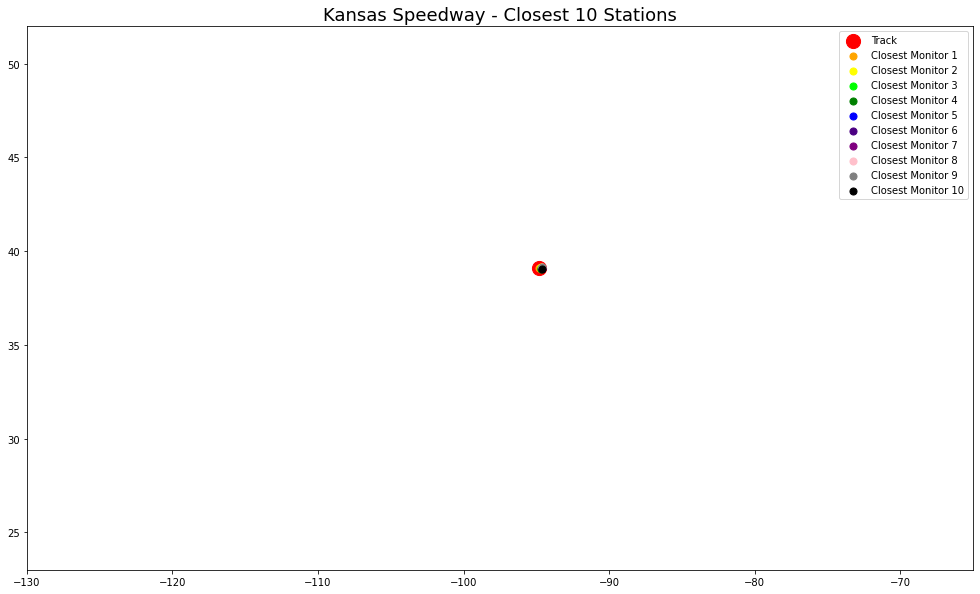

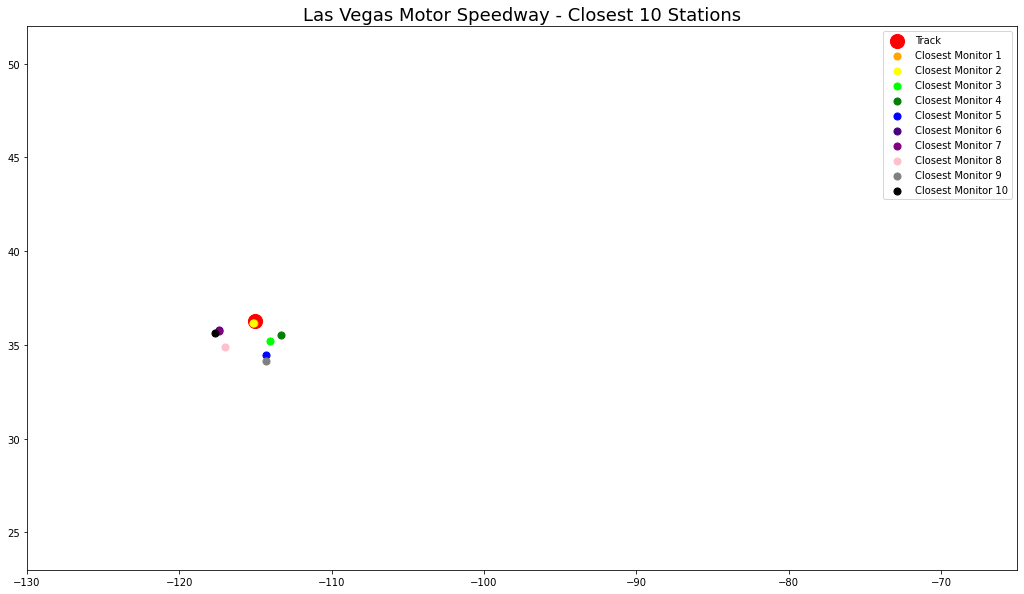

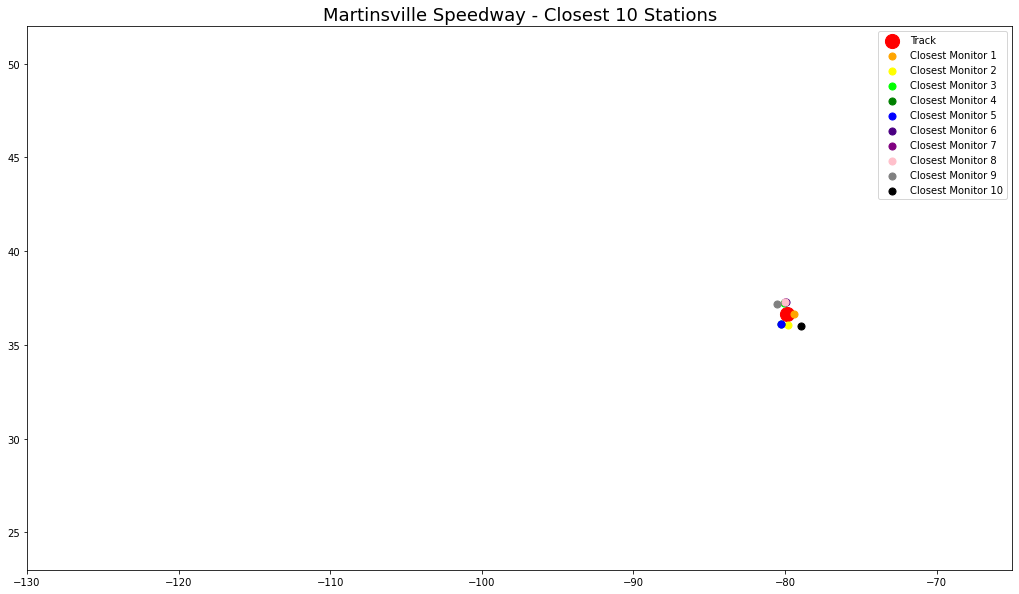

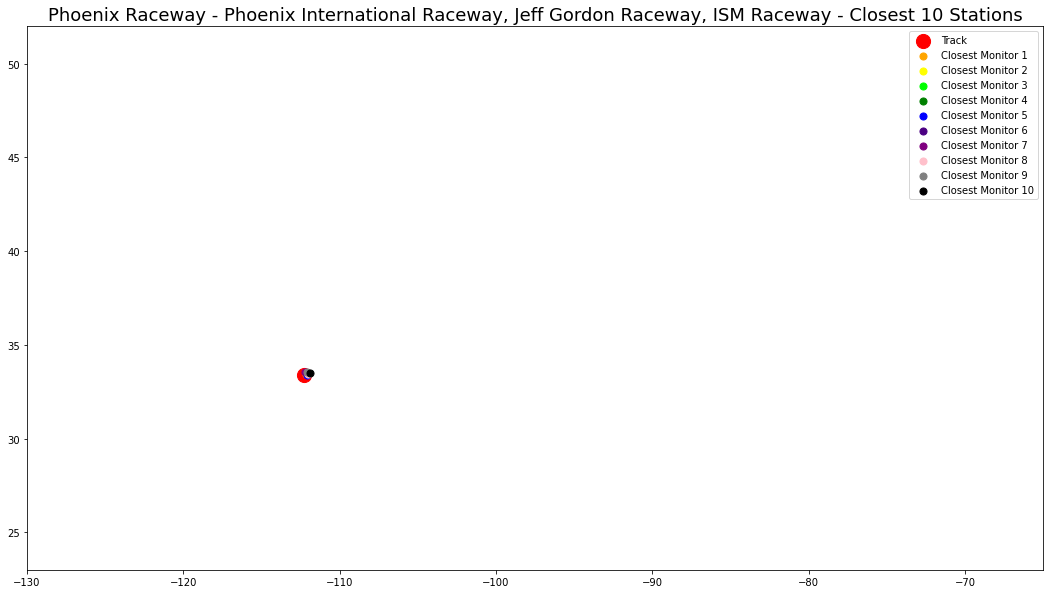

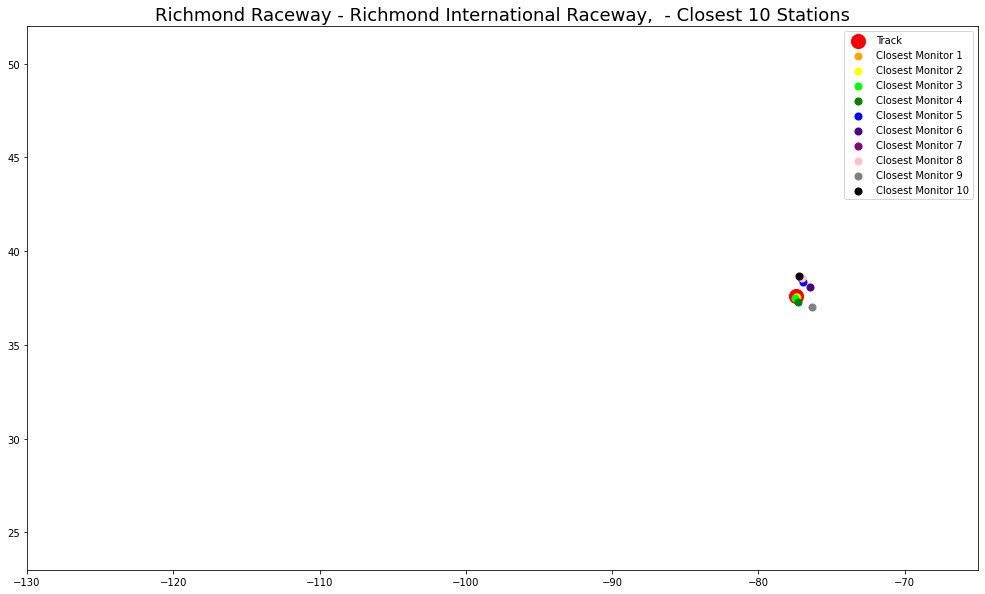

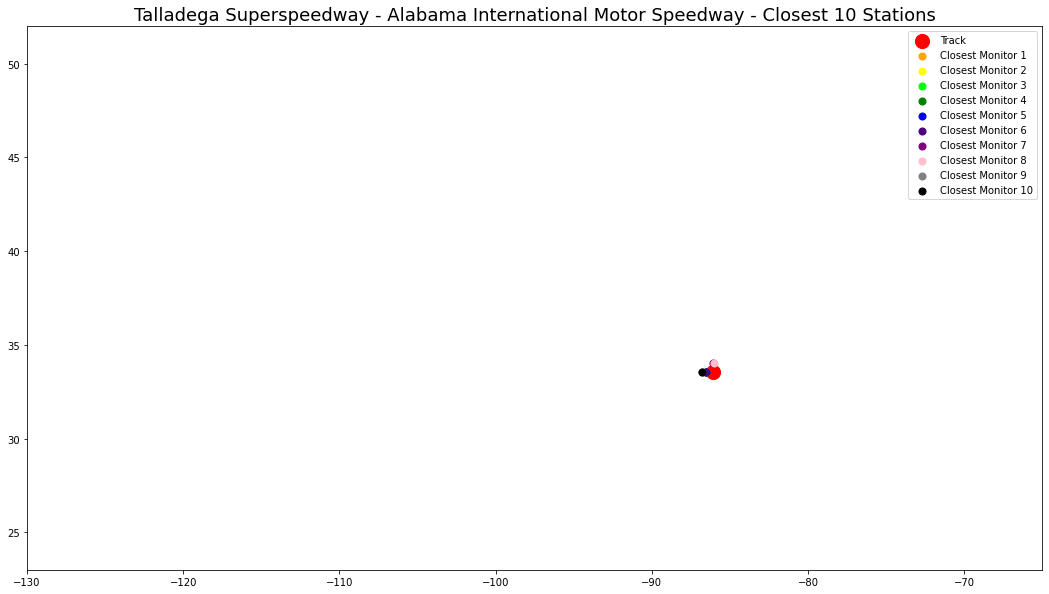

In [29]:
for i, df in nascar_tracks_df.iterrows():
    
    filt_nascar_tracks_df = df.to_frame().transpose()
    
    f, ax = plt.subplots(1, figsize=(20,10))

    geo = [Point(xy) for xy in zip(filt_nascar_tracks_df['long'], filt_nascar_tracks_df['lat'])] # note: (long, lat) order
    gdf = GeoDataFrame(filt_nascar_tracks_df, geometry=geo, crs = 4326)   

    ax = gdf.plot(ax=ax, marker='o', color='red', markersize=200, label="Track")

    for i in range(1,n_smallest+1):
        lat_col = f"closest_point_lat_{i}"
        long_col = f"closest_point_long_{i}"

        # note: (long, lat) order, ie (1,0)
        geo = [Point(xy) for xy in zip(filt_nascar_tracks_df[long_col], filt_nascar_tracks_df[lat_col])]
        gdf = GeoDataFrame(filt_nascar_tracks_df, geometry=geo, crs = 4326)  

        ax = gdf.plot(ax=ax, marker='o', color=get_color(i), markersize=50, label=f"Closest Monitor {i}")
        ax.set_xlim(-130,-65)
        ax.set_ylim(23,52)
    
    track_name = filt_nascar_tracks_df["track"].iloc[0]
    ax.set_title(f"{track_name} - Closest 10 Stations", fontsize=18)
    plt.legend()
    plt.show()

#### ** Discrepancy between # unique monitorID versus unique lat+long pairs**

In [30]:
len(daily_lead_df.drop_duplicates(["monitorID"]))

2459

In [31]:
len(daily_lead_df.drop_duplicates(["latitude","longitude"]))

2445

In [32]:
# more unique monitor IDs than unique lat/long coords